In [ ]:
import sys, subprocess

subprocess.run(
    [sys.executable, "-m", "pip", "uninstall", "-y",
     "flwr", "protobuf", "grpcio", "flwr-datasets"],
    check=False
)

subprocess.run(
    [sys.executable, "-m", "pip", "install", "--no-cache-dir",
     "protobuf==5.29.0",
     "grpcio>=1.60.0",
     "flwr[simulation]",
     "flwr-datasets[vision]",
     "torch",
     "torchvision",
     "matplotlib"],
    check=True
)

print("✅ Installation finished")
print("⚠️ NOW GO TO: Runtime → Restart runtime (MANDATORY)")


✅ Installation finished
⚠️ NOW GO TO: Runtime → Restart runtime (MANDATORY)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

import flwr as fl
from flwr.client import NumPyClient
from flwr.simulation import start_simulation
from flwr.server.strategy import FedAvg

from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner


DEVICE = torch.device("cpu")
print("Training on:", DEVICE)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train(net, loader):
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    net.train()
    for b in loader:
        opt.zero_grad()
        loss = loss_fn(net(b["img"]), b["label"])
        loss.backward()
        opt.step()


def test(net, loader):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for b in loader:
            preds = net(b["img"]).argmax(1)
            correct += (preds == b["label"]).sum().item()
            total += len(preds)
    return correct / total

def load_data(cid):
    fds = FederatedDataset(
        dataset="uoft-cs/cifar10",
        partitioners={"train": IidPartitioner(num_partitions=10)},
    )

    part = fds.load_partition(cid)
    split = part.train_test_split(test_size=0.2, seed=42)

    tf = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    split = split.with_transform(
        lambda b: {"img": [tf(x) for x in b["img"]], "label": b["label"]}
    )

    return (
        DataLoader(split["train"], batch_size=32, shuffle=True),
        DataLoader(split["test"], batch_size=32),
    )

class FlowerClient(NumPyClient):
    def __init__(self, cid):
        self.net = Net()
        self.trainloader, self.testloader = load_data(cid)

    def get_parameters(self, config):
        return [v.cpu().numpy() for v in self.net.state_dict().values()]

    def set_parameters(self, params):
        self.net.load_state_dict(
            dict(zip(self.net.state_dict().keys(), map(torch.tensor, params))),
            strict=True
        )

    def fit(self, params, config):
        self.set_parameters(params)
        train(self.net, self.trainloader)
        return self.get_parameters({}), len(self.trainloader.dataset), {}

    def evaluate(self, params, config):
        self.set_parameters(params)
        acc = test(self.net, self.testloader)
        return 0.0, len(self.testloader.dataset), {"accuracy": acc}


def client_fn(cid):
    return FlowerClient(int(cid)).to_client()


def aggregate(results):
    return {
        "accuracy": sum(n * m["accuracy"] for n, m in results) / sum(n for n, _ in results)
    }

history = start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=FedAvg(
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=aggregate,
    ),
)

print("Final Accuracy:", history.metrics_distributed["accuracy"][-1][1])


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

          

Training on: cpu


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-12-30 07:57:30,644	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, se

Final Accuracy: 0.1491


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


After increasing number of clients and rounds to 5


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor

import flwr as fl
from flwr.client import NumPyClient
from flwr.simulation import start_simulation
from flwr.server.strategy import FedAvg

from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_CLIENTS = 5
NUM_ROUNDS = 5
DEVICE = torch.device("cpu")

print("Device:", DEVICE)
print(f"Clients: {NUM_CLIENTS}, Rounds: {NUM_ROUNDS}")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def train(net, loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    net.train()

    for batch in loader:
        optimizer.zero_grad()
        loss = criterion(net(batch["img"]), batch["label"])
        loss.backward()
        optimizer.step()


def test(net, loader):
    net.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in loader:
            outputs = net(batch["img"])
            preds = outputs.argmax(1)
            correct += (preds == batch["label"]).sum().item()
            total += len(preds)

    return correct / total

def load_data(client_id):
    fds = FederatedDataset(
        dataset="uoft-cs/cifar10",
        partitioners={"train": IidPartitioner(num_partitions=NUM_CLIENTS)},
    )

    partition = fds.load_partition(client_id)
    split = partition.train_test_split(test_size=0.2, seed=42)

    transform = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    split = split.with_transform(
        lambda b: {"img": [transform(x) for x in b["img"]], "label": b["label"]}
    )

    trainloader = DataLoader(split["train"], batch_size=32, shuffle=True)
    testloader = DataLoader(split["test"], batch_size=32)

    return trainloader, testloader

class FlowerClient(NumPyClient):
    def __init__(self, cid):
        self.net = Net().to(DEVICE)
        self.trainloader, self.testloader = load_data(cid)

    def get_parameters(self, config):
        return [v.cpu().numpy() for v in self.net.state_dict().values()]

    def set_parameters(self, parameters):
        self.net.load_state_dict(
            dict(zip(self.net.state_dict().keys(), map(torch.tensor, parameters))),
            strict=True
        )

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader)
        return self.get_parameters({}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        accuracy = test(self.net, self.testloader)
        return 0.0, len(self.testloader.dataset), {"accuracy": accuracy}


def client_fn(cid):
    return FlowerClient(int(cid)).to_client()

def aggregate_metrics(results):
    total_examples = sum(num_examples for num_examples, _ in results)
    weighted_accuracy = sum(
        num_examples * metrics["accuracy"] for num_examples, metrics in results
    )
    return {"accuracy": weighted_accuracy / total_examples}

history = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=aggregate_metrics,
    ),
)

print("\n✅ Training completed")
print("Final Accuracy:", history.metrics_distributed["accuracy"][-1][1])


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout


Device: cpu
Clients: 5, Rounds: 5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-12-30 08:06:15,602	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3949581926.0, 'node:172.28.0.12': 1.0, 'memory': 9215691162.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial p


✅ Training completed
Final Accuracy: 0.1921


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


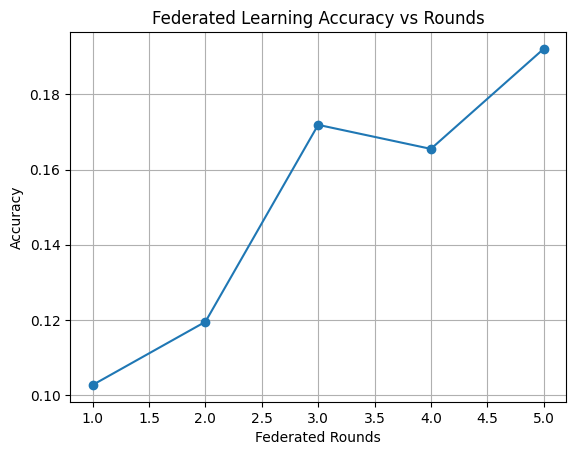

In [ ]:
import matplotlib.pyplot as plt

rounds = [r for r, _ in history.metrics_distributed["accuracy"]]
accuracies = [acc for _, acc in history.metrics_distributed["accuracy"]]

plt.figure()
plt.plot(rounds, accuracies, marker='o')
plt.xlabel("Federated Rounds")
plt.ylabel("Accuracy")
plt.title("Federated Learning Accuracy vs Rounds")
plt.grid(True)
plt.show()
